In [1]:
import pickle
import awkward as ak
import numpy as np
import vector
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mu=200

In [19]:
if mu==60:
    upper_mass_limit=400
if mu==200:
    upper_mass_limit=900

In [4]:
truth_file="data/results_mu"+str(mu)+"/data_combined_test_seed_42.pkl"
corrected_file="data/PhyGHT_mu"+str(mu)+"_10k_events_test_results.pkl"

In [5]:
with open(truth_file,"rb") as f:
    data = pickle.load(f)
    trks = data[2]

In [6]:
with open(corrected_file,"rb") as f:
    data = pickle.load(f)
    jets = data["jets"]
    jet_trk_IDs = data["jet_trk_IDs"]
mask = (jets[:,:,4]>0.1)&(jets[:,:,5]>0.1)
jets=jets[mask]
jet_trk_IDs=jet_trk_IDs[mask]

In [7]:
PLOT_CONFIG = { 
    # Fonts & Sizes (Compact for Paper)
    'FONT_FAMILY': 'serif',
    'FONT_SIZE': 20,
    'TITLE_SIZE': 22,
    'AXIS_LABEL_SIZE': 20,
    'TICK_SIZE': 20,
    'LEGEND_SIZE': 18,
    'LINE_WIDTH': 2.0,
    'DPI': 400,
    # --- 1D HISTOGRAM SETTINGS ---
    'BINS_1D': 50,
    'LOG_Y_1D': True,           # Y-axis log scale
    'COLOR_GT': '#333333',
    'COLOR_PRED': '#E24A33',
    # 1D Axis Ranges (Set to None for Auto)
    'X_LIM_1D': [0, 1.0],       # Correction Factor Range
    'Y_LIM_1D': [10, 1e5],      # Count Range (Min > 0 for Log)      
}

In [8]:
plt.rcParams.update({
    # 'font.family': PLOT_CONFIG['FONT_FAMILY'],
    'font.size': PLOT_CONFIG['FONT_SIZE'],
    'axes.labelsize': PLOT_CONFIG['AXIS_LABEL_SIZE'],
    'axes.titlesize': PLOT_CONFIG['TITLE_SIZE'],
    'xtick.labelsize': PLOT_CONFIG['TICK_SIZE'],
    'ytick.labelsize': PLOT_CONFIG['TICK_SIZE'],
    'legend.fontsize': PLOT_CONFIG['LEGEND_SIZE'],
    'lines.linewidth': PLOT_CONFIG['LINE_WIDTH'],
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
})

In [9]:
top_uncorrected = []
top_true_corrected = []
top_pred_corrected = []

# Loop over event
num_events=len(jets)
for event in tqdm(range(num_events)):
    # Loop over jets in the event
    num_jets = len(jets[event])
    jet_num_fromBottom = []
    jet_num_fromW = []
    jet_num_total=[]
    jet_pt=[]
    for jet in range(num_jets):
        num_trks = len(jet_trk_IDs[event][jet])
        num_total=0
        num_fromBottom=0
        num_fromW=0
        for trk in range(num_trks):
            ID = jet_trk_IDs[event][jet][trk]
            arg = np.ravel(np.argwhere(trks[event]==ID))[0]
            if trks[event][arg][0]<1:
                continue
            num_total+=1
            fromBottom = trks[event][arg][6]
            fromW = trks[event][arg][7]
            if fromBottom==1:
                num_fromBottom+=1
            if fromW==1:
                num_fromW+=1
            #print(ID, arg, trks[event][arg])
        jet_num_fromBottom.append(num_fromBottom)
        jet_num_fromW.append(num_fromW)
        jet_pt.append(float(jets[event][jet][0]))
        jet_num_total.append(num_total)
    #print(jet_num_fromBottom)
    #print(jet_num_fromW)
    #print(jet_num_total)
    #print(jet_pt)
    sorted_jet_num_fromBottom = np.argsort(jet_num_fromBottom)
    if len(sorted_jet_num_fromBottom)<1:
        continue
    sorted_jet_num_fromW = np.argsort(jet_num_fromW)
    if len(sorted_jet_num_fromW)<2:
        continue
    #print(sorted_jet_num_fromBottom)
    #print(sorted_jet_num_fromW)
    b_arg = sorted_jet_num_fromBottom[-1]
    W1_arg = sorted_jet_num_fromW[-1]
    W2_arg = sorted_jet_num_fromW[-2]
    if (b_arg==W1_arg) or (b_arg==W2_arg):
        continue
    b_jet = jets[event][b_arg]
    W1_jet = jets[event][W1_arg]
    W2_jet = jets[event][W2_arg]

    b_jet = vector.obj(pt=b_jet[0],eta=b_jet[1],phi=b_jet[2],m=b_jet[3])
    W1_jet = vector.obj(pt=W1_jet[0],eta=W1_jet[1],phi=W1_jet[2],m=W1_jet[3])
    W2_jet = vector.obj(pt=W2_jet[0],eta=W2_jet[1],phi=W2_jet[2],m=W2_jet[3])

    uncorrected_jet_list = [b_jet, W1_jet, W2_jet]
    efrac_true_list = [jets[event][b_arg][4], jets[event][W1_arg][4], jets[event][W2_arg][4]]
    mfrac_true_list = [jets[event][b_arg][5], jets[event][W1_arg][5], jets[event][W2_arg][5]]
    efrac_pred_list = [jets[event][b_arg][6], jets[event][W1_arg][6], jets[event][W2_arg][6]]
    mfrac_pred_list = [jets[event][b_arg][7], jets[event][W1_arg][7], jets[event][W2_arg][7]]
    
    true_corrected_jet_list = []
    pred_corrected_jet_list = []
    for i, jet in enumerate(uncorrected_jet_list):
        true_corrected_mass = jet.M*mfrac_true_list[i]
        pred_corrected_mass = jet.M*mfrac_pred_list[i]

        true_corrected_energy = jet.E*efrac_true_list[i]
        pred_corrected_energy = jet.E*efrac_pred_list[i]
        
        true_corrected_mag_p = np.sqrt(np.abs(np.square(true_corrected_energy)-np.square(true_corrected_mass)))
        true_corrected_pT = true_corrected_mag_p / np.cosh(jet.eta)

        pred_corrected_mag_p = np.sqrt(np.abs(np.square(pred_corrected_energy)-np.square(pred_corrected_mass)))
        pred_corrected_pT = pred_corrected_mag_p / np.cosh(jet.eta)

        true_corrected_jet = vector.obj(pt=true_corrected_pT,eta=jet.eta,phi=jet.phi,m=true_corrected_mass)
        pred_corrected_jet = vector.obj(pt=pred_corrected_pT,eta=jet.eta,phi=jet.phi,m=pred_corrected_mass)

        true_corrected_jet_list.append(true_corrected_jet)
        pred_corrected_jet_list.append(pred_corrected_jet)

    uncorrected_top_quark = sum(uncorrected_jet_list, start=vector.MomentumObject4D(px=0, py=0, pz=0, E=0))
    true_corrected_top_quark = sum(true_corrected_jet_list, start=vector.MomentumObject4D(px=0, py=0, pz=0, E=0))
    pred_corrected_top_quark = sum(pred_corrected_jet_list, start=vector.MomentumObject4D(px=0, py=0, pz=0, E=0))

    top_uncorrected.append(uncorrected_top_quark.m)
    top_true_corrected.append(true_corrected_top_quark.m)
    top_pred_corrected.append(pred_corrected_top_quark.m)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:15<00:00,  1.63it/s]


In [10]:
top_uncorrected=np.array(top_uncorrected)
top_true_corrected=np.array(top_true_corrected)
top_pred_corrected=np.array(top_pred_corrected)

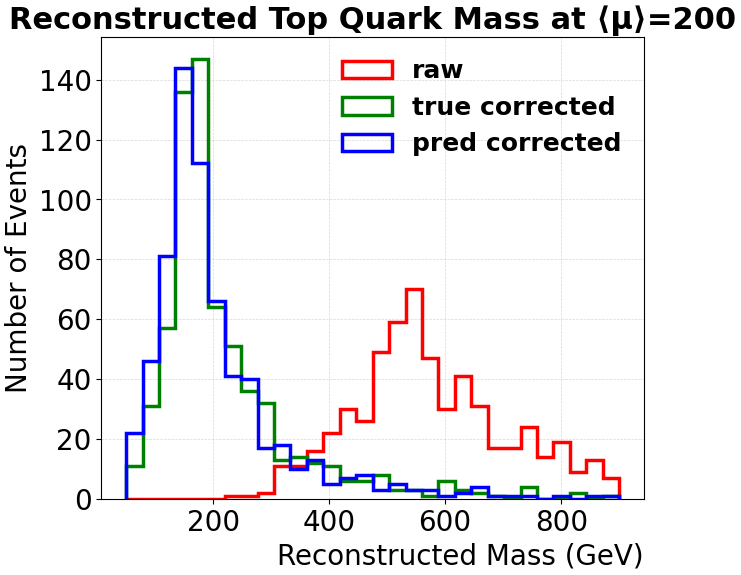

In [20]:
plt.figure(figsize=(7, 6))
plt.title("Reconstructed Top Quark Mass at \u27E8\u03BC\u27E9="+str(mu), weight='bold')
y_raw, x_raw, _ = plt.hist(top_uncorrected,range=(50,upper_mass_limit),bins=30,histtype='step',color='r',label='raw', linewidth=2.5)
y_true, x_true, _ = plt.hist(top_true_corrected,range=(50,upper_mass_limit),bins=30,histtype='step',color='g',label='true corrected', linewidth=2.5)
y_pred, x_pred, _ = plt.hist(top_pred_corrected,range=(50,upper_mass_limit),bins=30,histtype='step',color='b',label='pred corrected', linewidth=2.5)
plt.xlabel('Reconstructed Mass (GeV)',loc='right')
plt.ylabel('Number of Events')
plt.legend(frameon=False, loc='upper right', prop={'weight': 'bold'})
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
plt.savefig("Top_Mass_Reco_mu"+str(mu)+".png", dpi=PLOT_CONFIG['DPI'])
plt.show()

In [56]:
if mu==60:
    mean_min=120
    mean_max=225
    raw_min=150
    raw_max=400
if mu==200:
    mean_min=110
    mean_max=225
    raw_min=300
    raw_max=800

In [57]:
print("Top Mass Uncorrected:\t\tMean: ", round(np.mean(top_uncorrected),2)," STD: ", round(np.std(top_uncorrected),2))
print("Top Mass True Corrected:\tMean: ", round(np.mean(top_true_corrected[(top_true_corrected>mean_min)&(top_true_corrected<mean_max)]),2)," STD: ", round(np.std(top_true_corrected[(top_true_corrected>mean_min)&(top_true_corrected<mean_max)]),2))
print("Top Mass Pred Corrected:\tMean: ", round(np.mean(top_pred_corrected[(top_pred_corrected>mean_min)&(top_pred_corrected<mean_max)]),2)," STD: ", round(np.std(top_pred_corrected[(top_pred_corrected>mean_min)&(top_pred_corrected<mean_max)]),2))

Top Mass Uncorrected:		Mean:  719.6  STD:  452.19
Top Mass True Corrected:	Mean:  167.23  STD:  26.56
Top Mass Pred Corrected:	Mean:  164.44  STD:  29.37


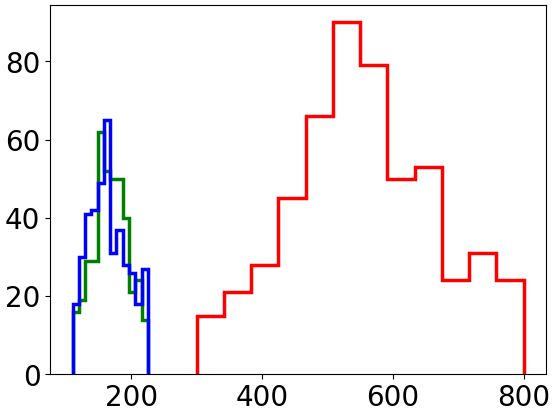

In [58]:
y_raw, x_raw, _ = plt.hist(top_uncorrected,range=(raw_min,raw_max),bins=12,histtype='step',color='r',label='raw', linewidth=2.5)
y_true, x_true, _ = plt.hist(top_true_corrected,range=(mean_min,mean_max),bins=12,histtype='step',color='g',label='true corrected', linewidth=2.5)
y_pred, x_pred, _ = plt.hist(top_pred_corrected,range=(mean_min,mean_max),bins=12,histtype='step',color='b',label='pred corrected', linewidth=2.5)

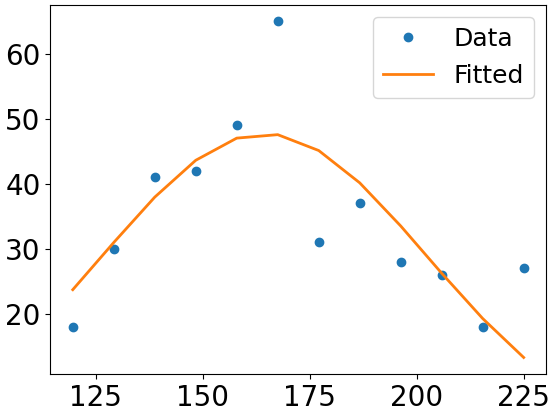

Fitted parameters: [ 47.7384001  164.39709655  37.88322797]


In [59]:
from scipy.optimize import curve_fit

# Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

#mask=(x_pred[1:]>mean_min)&(x_pred[1:]<mean_max)
x = x_pred[1:]
y = y_pred

# Provide initial parameter guesses
a_init = np.max(y)  # amplitude
x0_init = x[np.argmax(y)]  # center
sigma_init = (np.max(x) - np.min(x)) / 4  # width estimate

p0 = [a_init, x0_init, sigma_init]

popt, _ = curve_fit(func, x, y, p0=p0)
ym = func(x, *popt)

plt.plot(x, y, 'o', label='Data')
plt.plot(x, ym, label='Fitted')
plt.legend()
plt.show()

print("Fitted parameters:", popt)

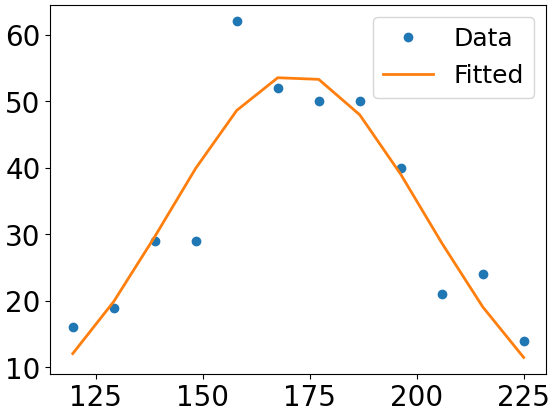

Fitted parameters: [ 54.10509815 171.86044333  30.18907176]


In [60]:
#mask=(x_true[1:]>mean_min)&(x_true[1:]<mean_max)
x = x_true[1:]
y = y_true

# Provide initial parameter guesses
a_init = np.max(y)  # amplitude
x0_init = x[np.argmax(y)]  # center
sigma_init = (np.max(x) - np.min(x)) / 4  # width estimate

p0 = [a_init, x0_init, sigma_init]

popt, _ = curve_fit(func, x, y, p0=p0)
ym = func(x, *popt)

plt.plot(x, y, 'o', label='Data')
plt.plot(x, ym, label='Fitted')
plt.legend()
plt.show()

print("Fitted parameters:", popt)

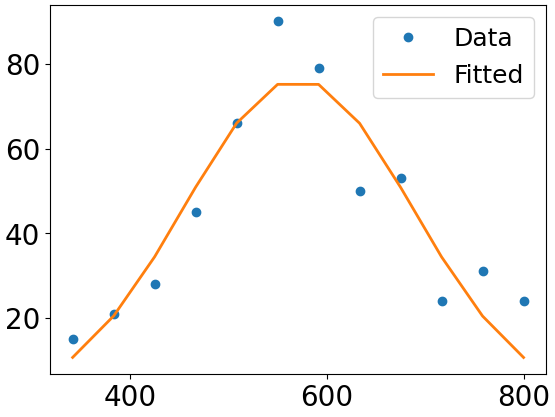

Fitted parameters: [ 76.38217478 570.79349909 115.49218237]


In [45]:
#mask=(x_raw[1:]>raw_min)&(x_raw[1:]<raw_max)
x = x_raw[1:]
y = y_raw

# Provide initial parameter guesses
a_init = np.max(y)  # amplitude
x0_init = x[np.argmax(y)]  # center
sigma_init = (np.max(x) - np.min(x)) / 4  # width estimate

p0 = [a_init, x0_init, sigma_init]

popt, _ = curve_fit(func, x, y, p0=p0)
ym = func(x, *popt)

plt.plot(x, y, 'o', label='Data')
plt.plot(x, ym, label='Fitted')
plt.legend()
plt.show()

print("Fitted parameters:", popt)